In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import copy

In [17]:
df=pd.read_csv("Combined Data\Combined_dataset.csv")

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\O\AppData\Local\Temp\ipykernel_13196\468677050.py:1: SyntaxWarning: invalid escape sequence '\C'
  df=pd.read_csv("Combined Data\Combined_dataset.csv")


In [18]:
df.head()

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI
0,Canada,SE649035-145565,River,12-01-1974,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent
1,Canada,SE649035-145565,River,12-01-1975,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent
2,Canada,SE649035-145565,River,12-01-1976,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent
3,Canada,SE649035-145565,River,12-01-1977,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent
4,Canada,SE649035-145565,River,12-01-1978,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827977 entries, 0 to 2827976
Data columns (total 14 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Country                           object 
 1   Area                              object 
 2   Waterbody Type                    object 
 3   Date                              object 
 4   Ammonia (mg/l)                    float64
 5   Biochemical Oxygen Demand (mg/l)  float64
 6   Dissolved Oxygen (mg/l)           float64
 7   Orthophosphate (mg/l)             float64
 8   pH (ph units)                     float64
 9   Temperature (cel)                 float64
 10  Nitrogen (mg/l)                   float64
 11  Nitrate (mg/l)                    float64
 12  CCME_Values                       float64
 13  CCME_WQI                          object 
dtypes: float64(9), object(5)
memory usage: 302.1+ MB


In [20]:
df.isnull().sum()

Country                             0
Area                                0
Waterbody Type                      0
Date                                0
Ammonia (mg/l)                      0
Biochemical Oxygen Demand (mg/l)    0
Dissolved Oxygen (mg/l)             0
Orthophosphate (mg/l)               0
pH (ph units)                       0
Temperature (cel)                   0
Nitrogen (mg/l)                     0
Nitrate (mg/l)                      0
CCME_Values                         0
CCME_WQI                            0
dtype: int64

In [21]:
df["CCME_WQI"].value_counts()

CCME_WQI
Good         1033709
Excellent    1020710
Marginal      328734
Fair          317856
Poor          126968
Name: count, dtype: int64

<Axes: xlabel='CCME_WQI'>

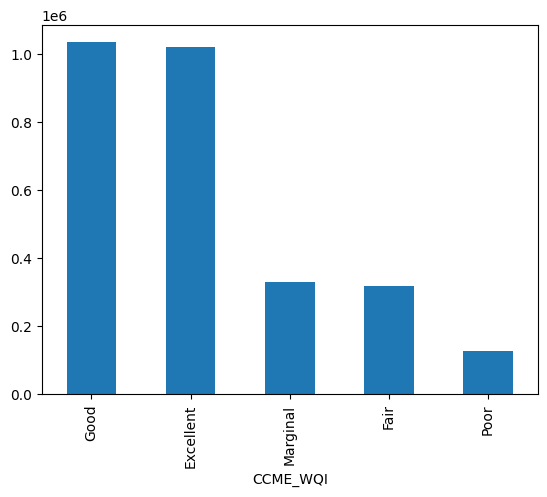

In [22]:
df["CCME_WQI"].value_counts().plot(kind="bar")

In [23]:
corr_data=df.select_dtypes(include="number").corr()

<Axes: >

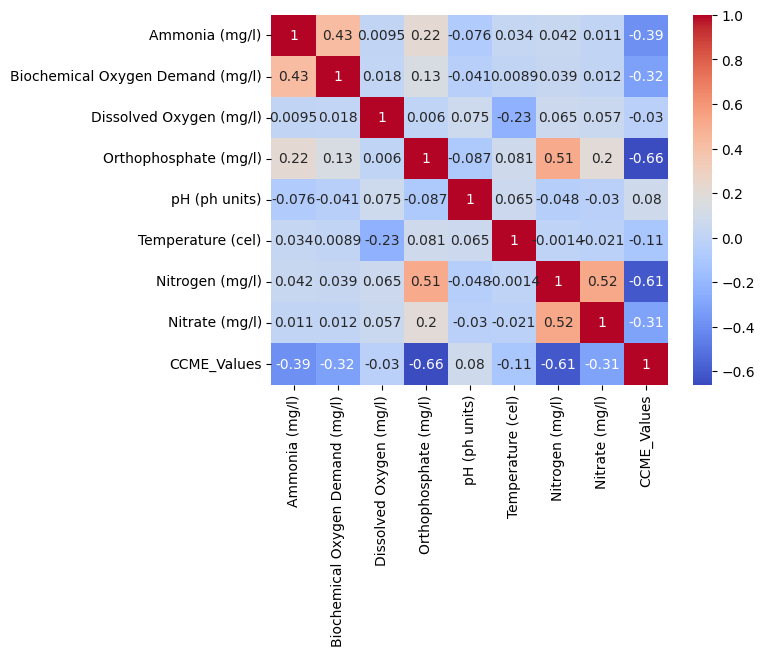

In [24]:
sns.heatmap(corr_data, annot=True, cmap='coolwarm')


In [25]:
df.duplicated().sum()

np.int64(9971)

In [26]:
df[df.duplicated()]
  
duplicates_grouped = df.groupby(list(df.columns)).size().reset_index(name='count')

 
duplicates_grouped[duplicates_grouped['count'] > 1]

 


,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI,count
94,Canada,CHRW-1339,River,12-01-2005,0.051060,0.930000,10.2160,0.0127,8.3167,10.9500,1.664290,5.245995,100.000000,Excellent,2
95,Canada,CHRW-1345,River,12-01-1999,0.137558,1.520000,10.5250,0.0124,8.3133,19.6667,1.245670,4.249920,100.000000,Excellent,2
96,Canada,CHRW-1345,River,12-01-2000,0.121072,1.500000,10.2500,0.1022,8.1975,11.6583,0.636642,4.382730,91.774842,Good,2
97,Canada,CHRW-1345,River,12-01-2001,0.177699,1.545390,9.0750,0.0230,8.1725,11.4250,12.500000,13.731226,100.000000,Excellent,2
98,Canada,CHRW-1345,River,12-01-2002,0.052107,0.558333,10.2167,0.0114,8.1700,10.7583,0.636364,5.091050,100.000000,Excellent,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817361,USA,Yuba,River,16-01-1962,0.021000,1.600000,9.8700,0.0400,7.8000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817416,USA,Yuba,River,16-12-1976,0.021000,1.600000,9.8700,0.0400,7.8000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817527,USA,Yuba,River,20-02-1962,0.021000,1.600000,9.8700,0.0400,7.3000,11.1000,0.400000,0.900000,100.000000,Excellent,2
2817531,USA,Yuba,River,20-02-2003,0.021000,1.600000,9.8700,0.0400,7.8000,1.4000,0.400000,0.900000,100.000000,Excellent,2


In [27]:
df.isna().sum()

Country                             0
Area                                0
Waterbody Type                      0
Date                                0
Ammonia (mg/l)                      0
Biochemical Oxygen Demand (mg/l)    0
Dissolved Oxygen (mg/l)             0
Orthophosphate (mg/l)               0
pH (ph units)                       0
Temperature (cel)                   0
Nitrogen (mg/l)                     0
Nitrate (mg/l)                      0
CCME_Values                         0
CCME_WQI                            0
dtype: int64

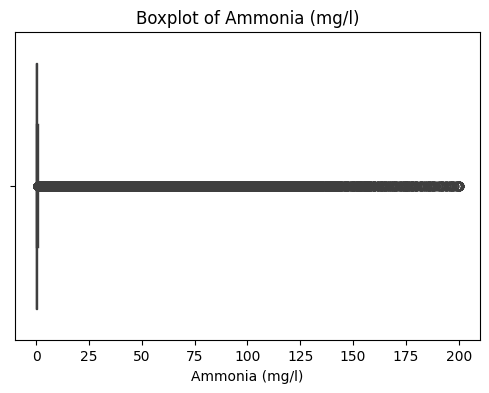

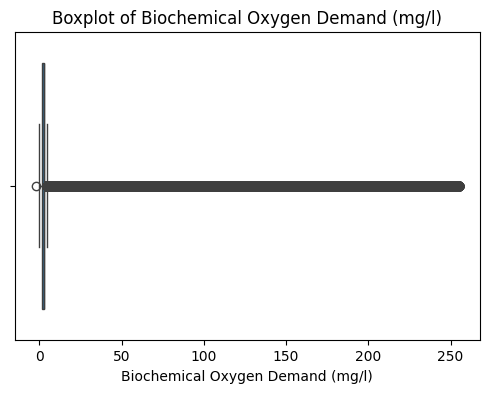

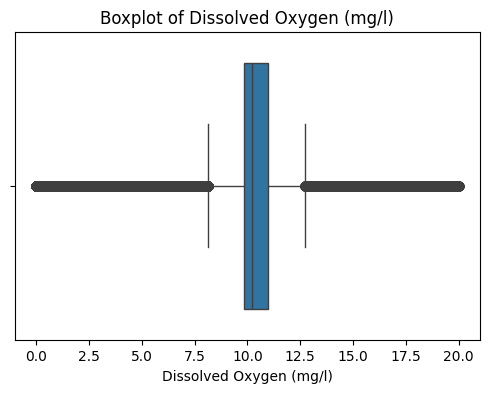

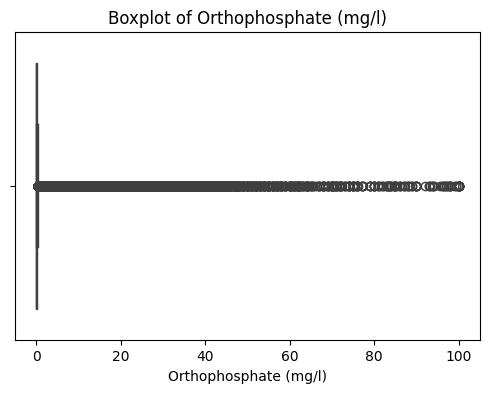

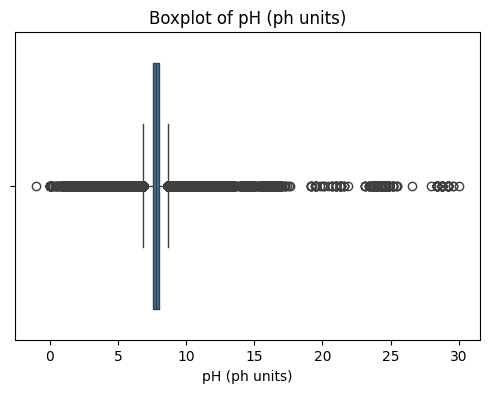

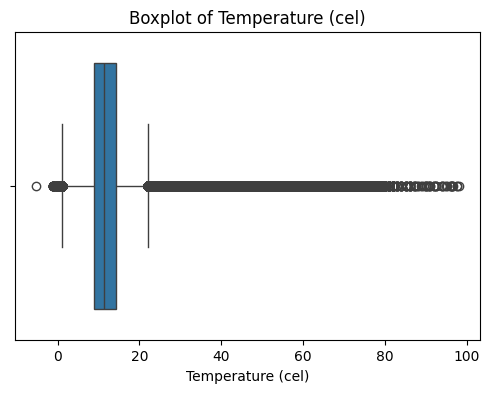

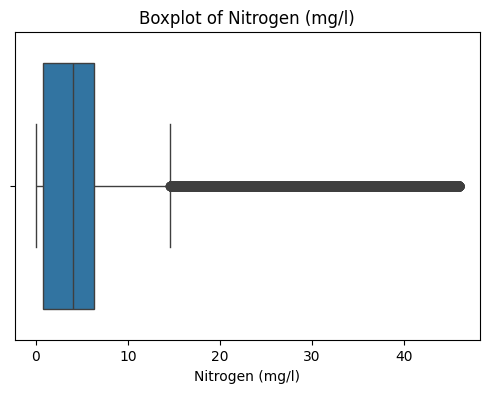

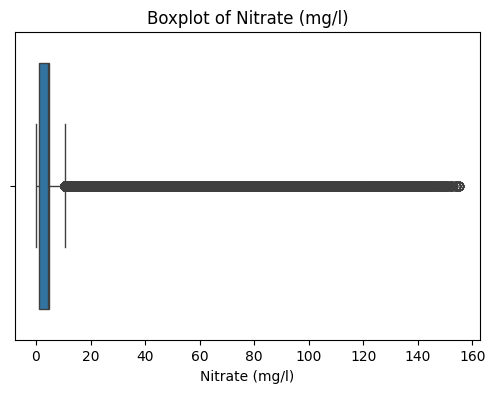

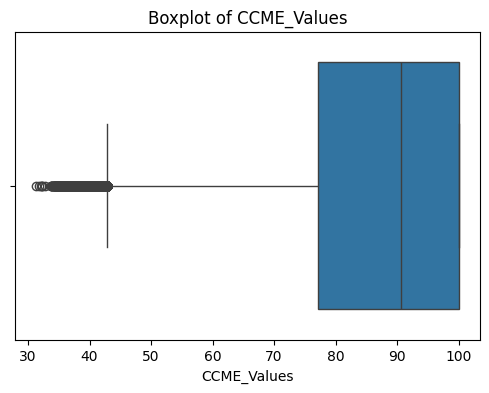

In [28]:
numeric_cols = df.select_dtypes(include="number").columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


Value counts for Country:
Country
England    2129198
USA         413814
Ireland     235019
China        45997
Canada        3949
Name: count, dtype: int64


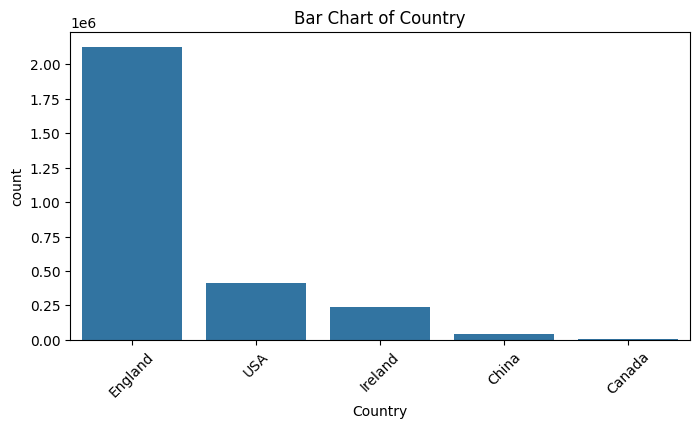


Value counts for Area:
Area
Lake Washington        54281
Hou Bay                45997
Lake Sammamish         26818
Central Puget Sound    22499
Los Angeles            21478
                       ...  
ES070ESPFBENI1             1
FRHR03105500               1
BADERANSKO-JEZERO          1
FISW_602                   1
DESM_DENI_48162282         1
Name: count, Length: 61689, dtype: int64


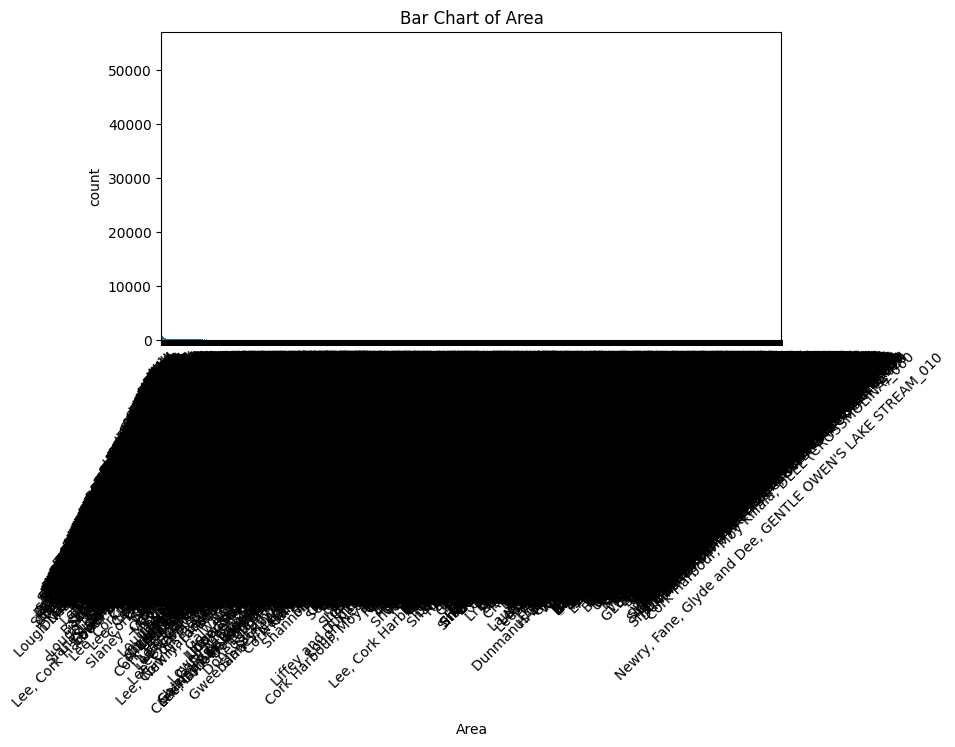


Value counts for Waterbody Type:
Waterbody Type
River           1852579
Effluent         601550
Lake             153603
Estuarine         49375
Bay               45997
Sea Water         32061
Canal             28574
Sewage            23777
Marine            23162
Drainage          10205
Transitional       4275
Coastal            2819
Name: count, dtype: int64


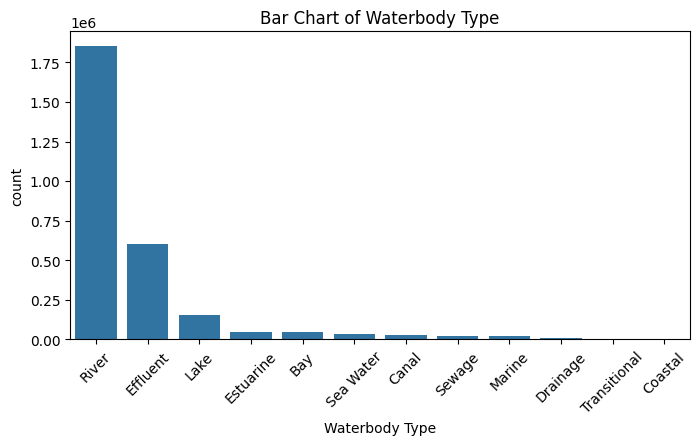


Value counts for Date:
Date
13-11-2008    922
12-03-2018    894
25-11-2013    881
19-11-2013    851
05-03-2014    837
             ... 
18-05-1996      1
23-12-2017      1
15-07-2023      1
23-10-1977      1
11-05-1994      1
Name: count, Length: 23876, dtype: int64


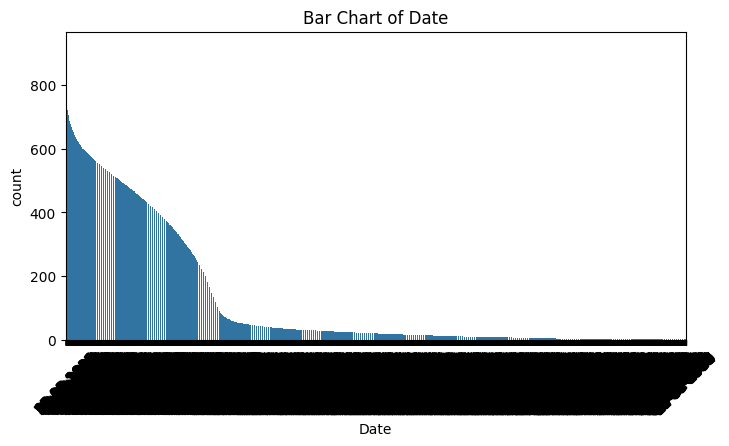


Value counts for CCME_WQI:
CCME_WQI
Good         1033709
Excellent    1020710
Marginal      328734
Fair          317856
Poor          126968
Name: count, dtype: int64


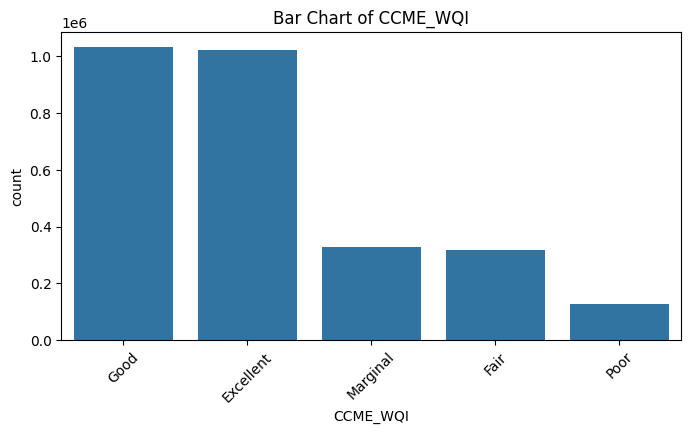

In [29]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())
    
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Bar Chart of {col}')
    plt.xticks(rotation=45)
    plt.show()

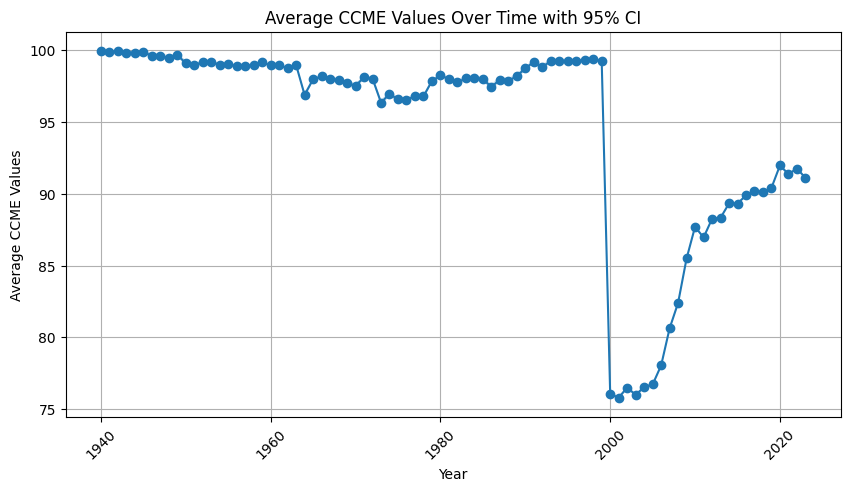

In [30]:
 

 
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

 
df["CCME_Values"] = pd.to_numeric(df["CCME_Values"], errors="coerce")

 
df["Year"] = df["Date"].dt.year

 
agg = df.groupby("Year")["CCME_Values"].agg(["mean","std","count"]).dropna()

 
agg["sem"] = agg["std"] / np.sqrt(agg["count"])
agg["ci95_low"] = agg["mean"] - 1.96 * agg["sem"]
agg["ci95_high"] = agg["mean"] + 1.96 * agg["sem"]

 
plt.figure(figsize=(10,5))
plt.plot(agg.index, agg["mean"], marker="o")
plt.fill_between(agg.index, agg["ci95_low"], agg["ci95_high"], alpha=0.2)
plt.xlabel("Year")
plt.ylabel("Average CCME Values")
plt.title("Average CCME Values Over Time with 95% CI")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


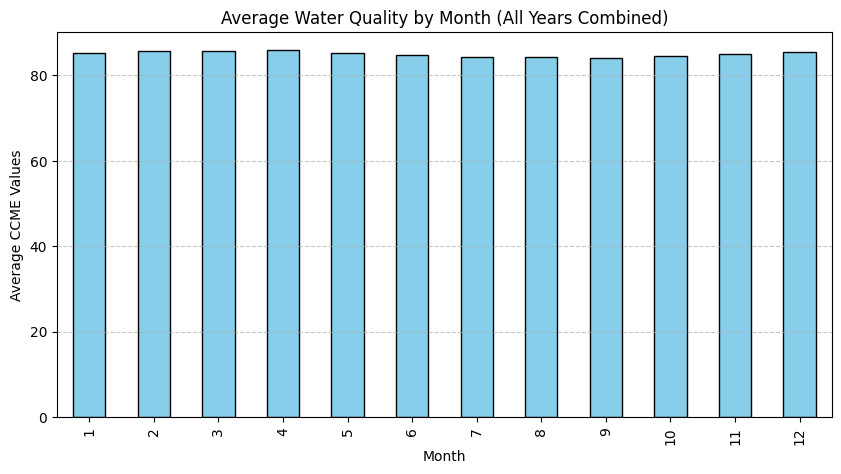

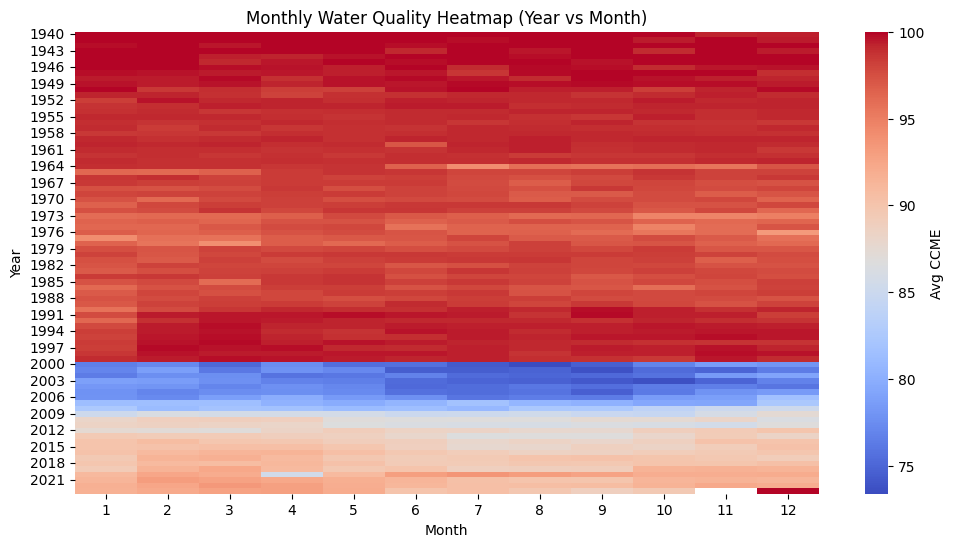

In [ ]:

df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
 
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

 
monthly_quality = df.groupby("Month")["CCME_Values"].mean()
plt.figure(figsize=(10, 5))
monthly_quality.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Month")
plt.ylabel("Average CCME Values")
plt.title("Average Water Quality by Month (All Years Combined)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


pivot = df.pivot_table(
    index="Year",
    columns="Month",
    values="CCME_Values",
    aggfunc="mean"
)

 
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="coolwarm", annot=False, cbar_kws={'label': 'Avg CCME'})
plt.title("Monthly Water Quality Heatmap (Year vs Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


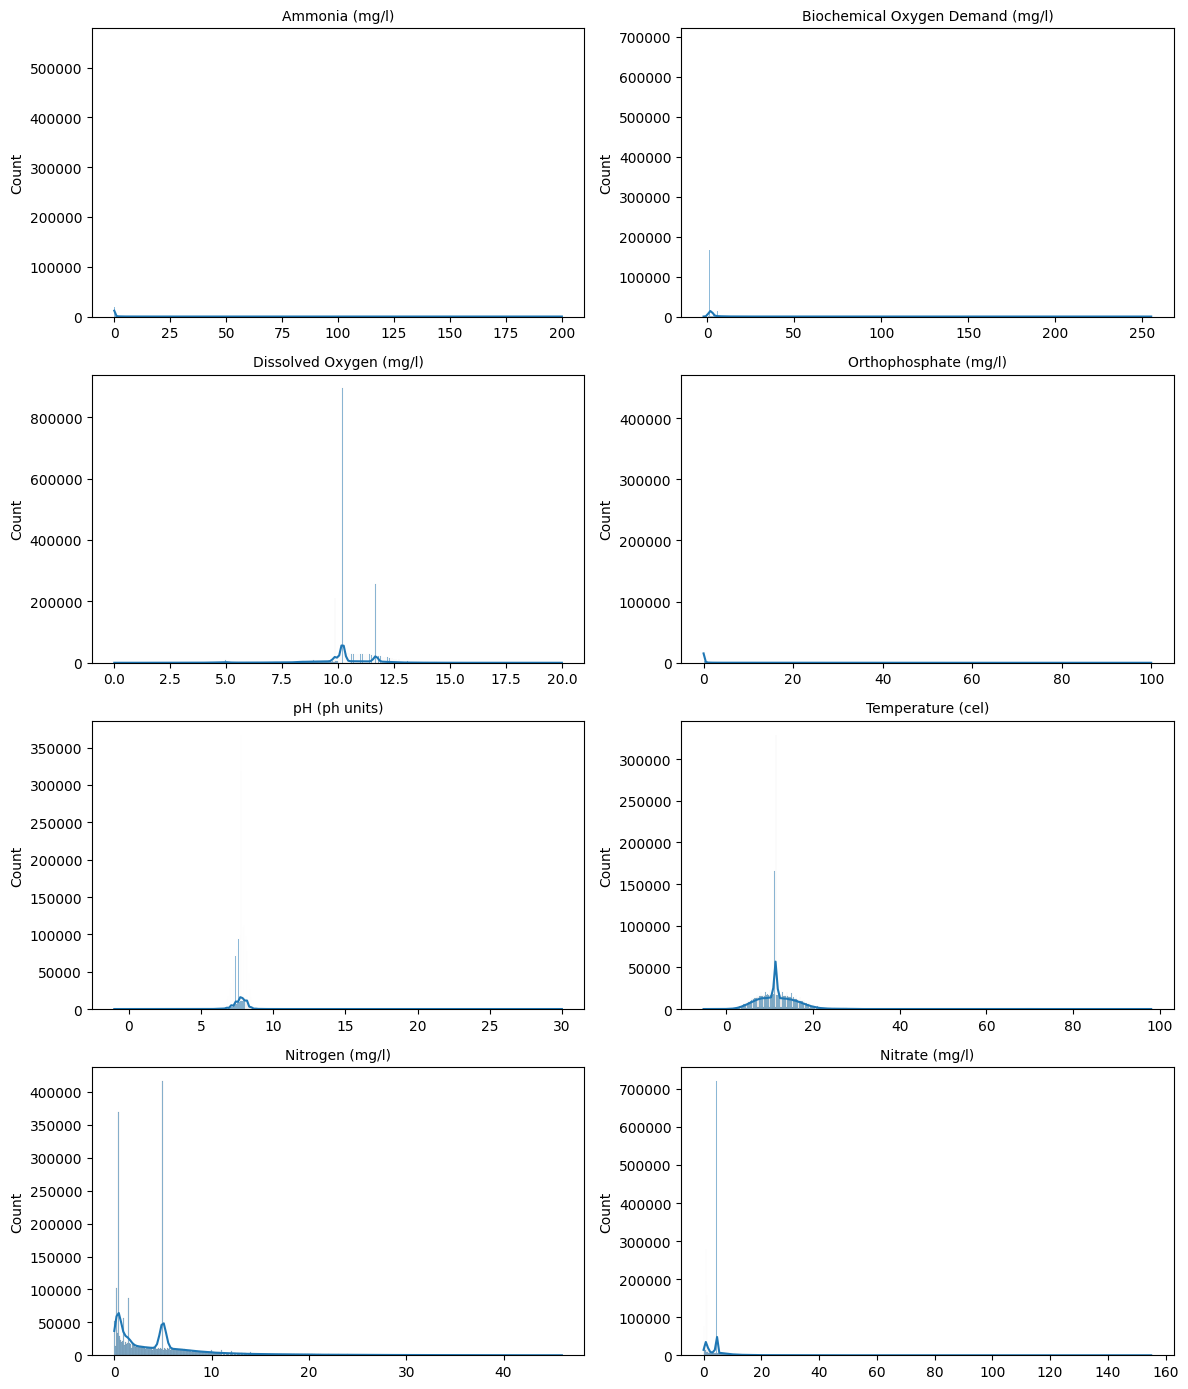

In [31]:
 

 
features = [
    "Ammonia (mg/l)", 
    "Biochemical Oxygen Demand (mg/l)",
    "Dissolved Oxygen (mg/l)", 
    "Orthophosphate (mg/l)",
    "pH (ph units)", 
    "Temperature (cel)", 
    "Nitrogen (mg/l)", 
    "Nitrate (mg/l)"
]

 
n_rows = 4
n_cols = 2

 
plt.figure(figsize=(12, 14))

 
for i, col in enumerate(features, 1):    
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"{col}", fontsize=10)
    plt.xlabel("")  
    plt.ylabel("Count")

plt.tight_layout()   
plt.show()


In [32]:
 
valid_ranges = {
    "Ammonia (mg/l)": (0, 20),
    "Biochemical Oxygen Demand (mg/l)": (0, 50),
    "Dissolved Oxygen (mg/l)": (2, 30),
    "Orthophosphate (mg/l)": (0, 10),
    "pH (ph units)": (4, 11),
    "Temperature (cel)": (0, 60),
    "Nitrogen (mg/l)": (0, 50),
    "Nitrate (mg/l)": (0, 100),
    "CCME_Values": (0, 100)
}

 
mask_valid = pd.Series(True, index=df.index)

for col, (low, high) in valid_ranges.items():
    mask_valid &= df[col].between(low, high, inclusive="both")

 
df_clean = df[mask_valid].copy()

 
print("Before cleaning:", df.shape[0], "rows")
print("After cleaning:", df_clean.shape[0], "rows")
print("Removed:", df.shape[0] - df_clean.shape[0], "illogical rows")

Before cleaning: 2827977 rows
After cleaning: 2734630 rows
Removed: 93347 illogical rows


In [33]:
df_clean

,Country,Area,Waterbody Type,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),Nitrate (mg/l),CCME_Values,CCME_WQI,Year
0,Canada,SE649035-145565,River,1974-01-12,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,11.73155,100.0,Excellent,1974
1,Canada,SE649035-145565,River,1975-01-12,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,11.82009,100.0,Excellent,1975
2,Canada,SE649035-145565,River,1976-01-12,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,14.87472,100.0,Excellent,1976
3,Canada,SE649035-145565,River,1977-01-12,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,15.89293,100.0,Excellent,1977
4,Canada,SE649035-145565,River,1978-01-12,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,15.22888,100.0,Excellent,1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827972,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-06-21,0.024000,1.40,4.2930,0.025000,7.90000,16.200,0.370000,0.37000,100.0,Excellent,2022
2827973,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-09-28,0.038000,1.40,4.4955,0.025000,7.90000,11.400,0.540000,0.54000,100.0,Excellent,2022
2827974,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2022-11-29,0.035000,1.40,4.4640,0.016000,7.60000,6.200,0.800000,0.79000,100.0,Excellent,2022
2827975,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",River,2023-02-07,0.046000,1.40,4.1760,0.012000,8.00000,7.800,0.950000,1.30000,100.0,Excellent,2023


In [34]:
df_clean = df_clean.drop_duplicates()

 
print("Number of rows after removing duplicates:", df_clean.shape[0])

Number of rows after removing duplicates: 2724675


In [39]:
 
df_clean['Waterbody Type'] = df_clean['Waterbody Type'].replace({
    'Marine': 'Coastal/Marine',
    'Sea Water': 'Coastal/Marine',
    'Coastal': 'Coastal/Marine',
    'Estuarine': 'Coastal/Marine',
    'Sewage': 'Wastewater',
    'Effluent': 'Wastewater',
    'Canal': 'Artificial',
    'Drainage': 'Artificial'
})

 
df_encoded = pd.get_dummies(df_clean, columns=['Waterbody Type'],dtype="int")



C:\Users\O\AppData\Local\Temp\ipykernel_13196\3243783277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Waterbody Type'] = df_clean['Waterbody Type'].replace({


In [40]:
df_encoded

,Country,Area,Date,Ammonia (mg/l),Biochemical Oxygen Demand (mg/l),Dissolved Oxygen (mg/l),Orthophosphate (mg/l),pH (ph units),Temperature (cel),Nitrogen (mg/l),...,CCME_Values,CCME_WQI,Year,Waterbody Type_Artificial,Waterbody Type_Bay,Waterbody Type_Coastal/Marine,Waterbody Type_Lake,Waterbody Type_River,Waterbody Type_Transitional,Waterbody Type_Wastewater
0,Canada,SE649035-145565,1974-01-12,0.059248,1.30,8.1500,0.011917,8.07500,9.885,0.343917,...,100.0,Excellent,1974,0,0,0,0,1,0,0
1,Canada,SE649035-145565,1975-01-12,0.039821,1.38,7.8000,0.009417,7.73333,10.150,0.449083,...,100.0,Excellent,1975,0,0,0,0,1,0,0
2,Canada,SE649035-145565,1976-01-12,0.031341,2.23,7.8000,0.011000,7.46667,10.235,0.220750,...,100.0,Excellent,1976,0,0,0,0,1,0,0
3,Canada,SE649035-145565,1977-01-12,0.020501,1.61,8.1500,0.012333,7.78333,11.116,0.572250,...,100.0,Excellent,1977,0,0,0,0,1,0,0
4,Canada,SE649035-145565,1978-01-12,0.020023,1.64,4.3708,0.006182,7.10000,7.068,0.371091,...,100.0,Excellent,1978,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827972,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-06-21,0.024000,1.40,4.2930,0.025000,7.90000,16.200,0.370000,...,100.0,Excellent,2022,0,0,0,0,1,0,0
2827973,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-09-28,0.038000,1.40,4.4955,0.025000,7.90000,11.400,0.540000,...,100.0,Excellent,2022,0,0,0,0,1,0,0
2827974,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2022-11-29,0.035000,1.40,4.4640,0.016000,7.60000,6.200,0.800000,...,100.0,Excellent,2022,0,0,0,0,1,0,0
2827975,Ireland,"Cork Harbour, Moy Killala, YELLOW (KNOCK)_020",2023-02-07,0.046000,1.40,4.1760,0.012000,8.00000,7.800,0.950000,...,100.0,Excellent,2023,0,0,0,0,1,0,0


In [43]:
X = df_encoded.drop(columns=["CCME_WQI","Country","Area","Date","Year","CCME_Values"])   
y = df_encoded["CCME_WQI"]


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [45]:
 

# 1. Define custom order for classes
class_order = ["Poor", "Marginal", "Fair", "Good", "Excellent"]

# 2. Convert CCME_WQI column to categorical with fixed order
cat_type = pd.CategoricalDtype(categories=class_order, ordered=True)
y = y.astype(cat_type)

# 3. Encode to integer based on custom order
y_int = y.cat.codes.values

# 4. Features
num_features = [
    "Ammonia (mg/l)", "Biochemical Oxygen Demand (mg/l)",
    "Dissolved Oxygen (mg/l)", "Orthophosphate (mg/l)",
    "pH (ph units)", "Temperature (cel)",
    "Nitrogen (mg/l)", "Nitrate (mg/l)"
]

 
num_X = X[num_features]
cat_X = X.drop(columns=num_features )   
# 5. Train-Test split
X_train_num, X_test_num, y_train, y_test, cat_train, cat_test = train_test_split(
    num_X, y_int, cat_X, test_size=0.2, random_state=42, stratify=y_int
)

# 6. Preprocessing pipeline  
numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)
    ]
)

# 7. Transform numerical features
X_train_num_processed = preprocessor.fit_transform(X_train_num)
X_test_num_processed = preprocessor.transform(X_test_num)

X_train_processed = np.hstack([X_train_num_processed, cat_train.values])
X_test_processed = np.hstack([X_test_num_processed, cat_test.values])

# -------------------------------
# ✅ Final prints
# -------------------------------
print("Class mapping:", dict(zip(class_order, range(len(class_order)))))
print("Shape of data before:", X_train_num.shape, "+", cat_train.shape)
print("Shape of data after:", X_train_processed.shape)

print("\ny_train (integers) sample:")
for i, cls in enumerate(class_order):
    idx = np.where(y_train == i)[0][0]
    print(f"{cls} → {y_train[idx]}")


Class mapping: {'Poor': 0, 'Marginal': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4}
Shape of data before: (2179740, 8) + (2179740, 7)
Shape of data after: (2179740, 15)

y_train (integers) sample:
Poor → 0
Marginal → 1
Fair → 2
Good → 3
Excellent → 4


In [46]:
 

 
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42, stratify=y_train
)

 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_split, y_train_split)

print("Before SMOTE:", X_train_split.shape, "→ After SMOTE:", X_train_res.shape)
 
X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.long)    

X_val_tensor   = torch.tensor(X_val_split, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_split, dtype=torch.long)

X_test_tensor  = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

 
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


Before SMOTE: (1743792, 15) → After SMOTE: (3276835, 15)


In [51]:
 
 
# ---------------------
# 1. DNN Model
# ---------------------
class WaterQualityDNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.3):
        super(WaterQualityDNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))  
            prev_dim = h
        
        layers.append(nn.Linear(prev_dim, output_dim))    
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# ---------------------
# 2. Model Definition
# ---------------------
input_dim = 15  
output_dim = 5  
hidden_dims = [64, 32]
model = WaterQualityDNN(input_dim, hidden_dims, output_dim, dropout=0.6)

# ---------------------
# 3. Weight Initialization
# ---------------------
class_counts = np.bincount(y_train)   
weights = 1.0 / class_counts
weights = weights / weights.sum()
weights = torch.tensor(weights, dtype=torch.float32)
# ---------------------
# 4. Optimizer + Scheduler
# ---------------------
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


# Reduce LR if val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

print(model)


WaterQualityDNN(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6, inplace=False)
    (8): Linear(in_features=32, out_features=5, bias=True)
  )
)


In [52]:
class_counts = np.bincount(y_train)   
weights = 1.0 / class_counts
weights = weights / weights.sum()   
weights = torch.tensor(weights, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [53]:
 
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        # Add a new attribute to store the best epoch
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.best_epoch = epoch # Store the current epoch as the best one
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.best_epoch = epoch # Update the best epoch

Epoch [1/200], Train Loss: 0.3987, Val Loss: 0.3825
Epoch [2/200], Train Loss: 0.3481, Val Loss: 0.3354
Epoch [3/200], Train Loss: 0.3414, Val Loss: 0.3436
Epoch [4/200], Train Loss: 0.3382, Val Loss: 0.3519
Epoch [5/200], Train Loss: 0.3357, Val Loss: 0.3520
Epoch [6/200], Train Loss: 0.3345, Val Loss: 0.3597
Epoch [7/200], Train Loss: 0.3339, Val Loss: 0.3530
Epoch [8/200], Train Loss: 0.3326, Val Loss: 0.3571
Epoch [9/200], Train Loss: 0.3325, Val Loss: 0.3602
Epoch [10/200], Train Loss: 0.3322, Val Loss: 0.3344
Epoch [11/200], Train Loss: 0.3316, Val Loss: 0.3402
Epoch [12/200], Train Loss: 0.3315, Val Loss: 0.3453
Epoch [13/200], Train Loss: 0.3312, Val Loss: 0.4517
Epoch [14/200], Train Loss: 0.3305, Val Loss: 0.3848
Epoch [15/200], Train Loss: 0.3302, Val Loss: 0.3443
Epoch [16/200], Train Loss: 0.3297, Val Loss: 0.3487
Epoch [17/200], Train Loss: 0.3305, Val Loss: 0.3783
Epoch [18/200], Train Loss: 0.3302, Val Loss: 0.4016
Epoch [19/200], Train Loss: 0.3300, Val Loss: 0.3313
Ep

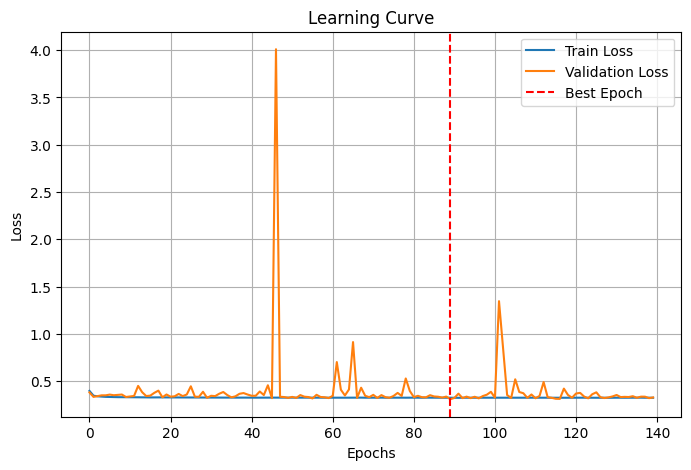

In [54]:
 

epochs = 200
early_stopping = EarlyStopping(patience=50)
train_losses = []
val_losses = []

for epoch in range(epochs):
    # ---- Train -----
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val.long())
            val_loss += loss.item()

    # Average losses
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Pass the current epoch number to the EarlyStopping object
    early_stopping(avg_val_loss, model, epoch + 1)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break

# Restore the best model state after the loop ends
if early_stopping.best_model_state is not None:
    model.load_state_dict(early_stopping.best_model_state)
    print("Best model state restored.")

# ------------------------
# Learning Curve Plot
# ------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

# Plot the vertical line at the best epoch
plt.axvline(early_stopping.best_epoch - 1, color='r', linestyle='--', label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
all_preds = []
all_labels = []
all_probs = []

 
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
         
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        labels = y_batch.cpu().numpy().astype(int)

         
        all_preds.extend(preds)
        all_labels.extend(labels)
        all_probs.extend(probs)

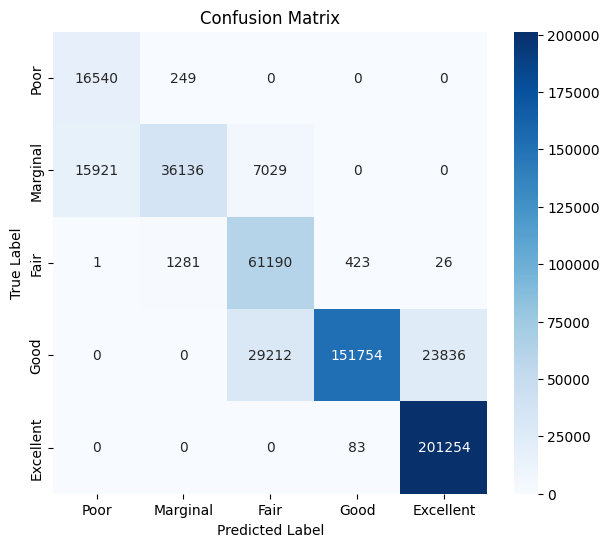

In [56]:
 

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_order)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
             xticklabels=class_order, yticklabels=class_order)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [57]:
 
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_order))

Classification Report:
              precision    recall  f1-score   support

        Poor       0.51      0.99      0.67     16789
    Marginal       0.96      0.61      0.75     59086
        Fair       0.63      0.97      0.76     62921
        Good       1.00      0.74      0.85    204802
   Excellent       0.89      1.00      0.94    201337

    accuracy                           0.86    544935
   macro avg       0.80      0.86      0.80    544935
weighted avg       0.90      0.86      0.86    544935



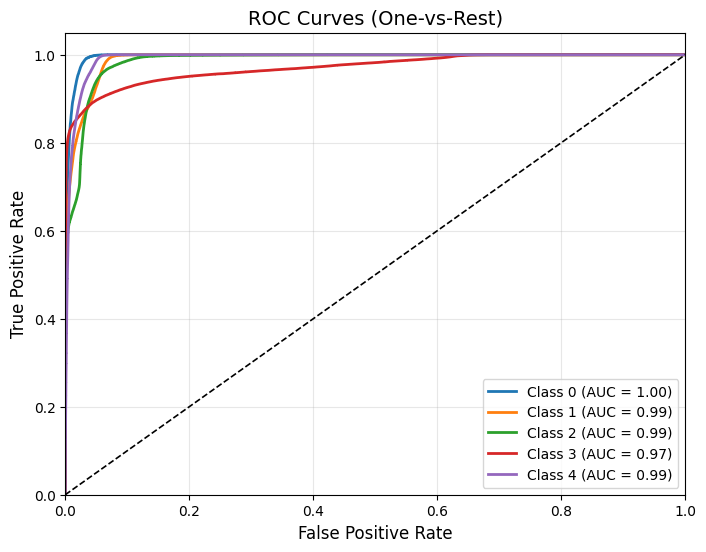

In [58]:
 
n_classes = len(np.unique(all_labels))
y_true_bin = label_binarize(all_labels, classes=np.arange(n_classes))
all_probs = np.array(all_probs)
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves (One-vs-Rest)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
